<font face="Chalkboard" color="darkgreen" size=6pt> LOWESS - Applied Comparisons w/ Real Data Applications</font>

The main idea is that we want to use many different kernels for the weights and validate the results.

In [133]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [134]:
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split as tts, KFold
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from math import ceil
from IPython.display import Image
from IPython.display import display
plt.style.use('seaborn-white')

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [135]:
lm = LinearRegression()
scale = StandardScaler()

## Kernel Definitions

To acommodate multidimensional featured observations we need to rewrite the code for the kernel functions.

**Class Discussion**: understand why we need this and how we implement this modification.

In [159]:
# Gaussian Kernel
def Gaussian(x):
  if len(x.shape)==1:
    d = np.abs(x)
  else:
    d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*d**2))

In [160]:
# Tricubic Kernel
def Tricubic(x):
  if len(x.shape)==1:
    d = np.abs(x)
  else:
    d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

In [161]:
# Epanechnikov Kernel
def Epanechnikov(x):
  if len(x.shape)==1:
    d = np.abs(x)
  else:
    d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,3/4*(1-d**2)) 

In [162]:
# Quartic Kernel
def Quartic(x):
  if len(x.shape)==1:
    d = np.abs(x)
  else:
    d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,15/16*(1-d**2)**2) 

## Useful Functions

Big Idea: we need to acommodate new data points in a test set. We can only get weights from the train set.

In [163]:
def kernel_function(xi,x0,kern, tau): 
    return kern((xi - x0)/(2*tau))

In [164]:
def weights_matrix(x,x_new,kern,tau):
  if np.isscalar(x_new):
    return kernel_function(x,x_new,kern,tau)
  else:
    n = len(x_new)
    return np.array([kernel_function(x,x_new[i],kern,tau) for i in range(n)])

## Scikit-Learn Compliant Functions

Main Idea: we want to define a model regressor that can be used as model.fit/model.predict, and that also allows sklearn GridSearchCV for tuning hyperparameters.

*Self* represents the instance of the class. By using the “self”  we can access the attributes and methods of the class in python. It binds the attributes with the given arguments.

In [143]:
class Lowess:
    def __init__(self, kernel = Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau
    
    def fit(self, x, y):
        kernel = self.kernel
        tau = self.tau
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_

        w = weights_matrix(x,x_new,self.kernel,self.tau)

        if np.isscalar(x_new):
          lm.fit(np.diag(w).dot(x.reshape(-1,1)),np.diag(w).dot(y.reshape(-1,1)))
          yest = lm.predict([[x_new]])[0][0]
        elif len(x.shape)==1:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[i,:]).dot(x.reshape(-1,1)),np.diag(w[i,:]).dot(y.reshape(-1,1)))
            yest_test[i] = lm.predict(x_new[i].reshape(-1,1))
        else:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[i,:]).dot(x),np.diag(w[i,:]).dot(y.reshape(-1,1)))
            yest_test[i] = lm.predict(x_new[i].reshape(1,-1))
        return yest_test

## Testing on Simulated Data

In [151]:
#Initializing noisy non linear data
x = np.linspace(0,4,401)
noise = np.random.normal(loc = 0, scale = .2, size = len(x))
y = np.sin(x**2 * 1.5 * np.pi ) 
ynoisy = y + noise

In [152]:
xtrain, xtest, ytrain, ytest = tts(x,ynoisy,test_size=0.2,shuffle=True,random_state=123)

In [153]:
%%time
# test the regressor
model = Lowess(kernel=Epanechnikov,tau=0.02)
model.fit(xtrain,ytrain)
mse(model.predict(xtest),ytest)

CPU times: user 87.4 ms, sys: 91.5 ms, total: 179 ms
Wall time: 132 ms


0.04396637303758067

In [154]:
%%time
model_rf = RandomForestRegressor(n_estimators=200, max_depth=20)
model_rf.fit(xtrain.reshape(-1,1),ytrain)
mse(model_rf.predict(xtest.reshape(-1,1)),ytest)

CPU times: user 471 ms, sys: 8.45 ms, total: 480 ms
Wall time: 531 ms


0.05400380567941156

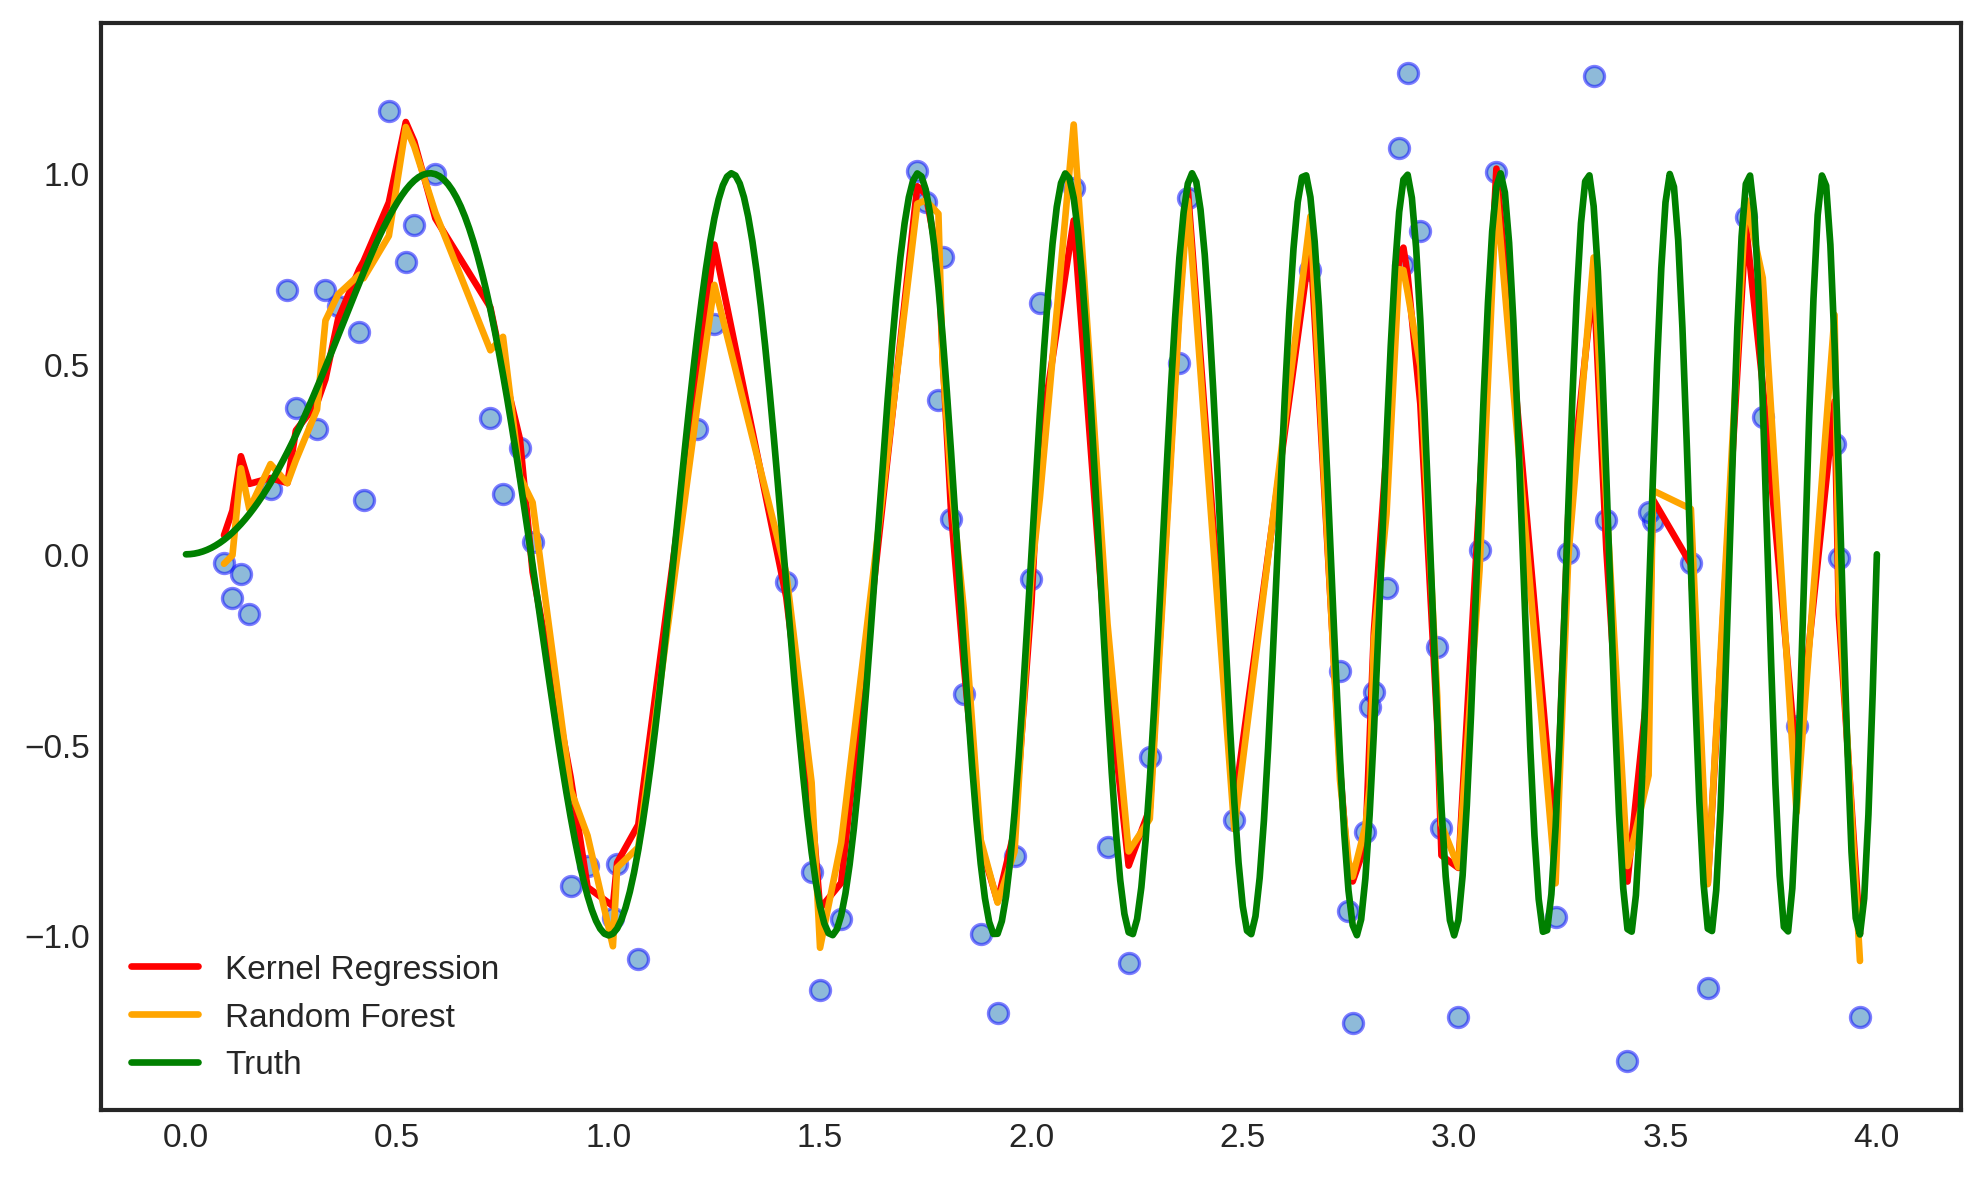

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(xtest,ytest,ec='blue',alpha=0.5)
plt.plot(xtest[np.argsort(xtest)],model.predict(xtest[np.argsort(xtest)]),color='red',lw=2,label='Kernel Regression')
plt.plot(xtest[np.argsort(xtest)],model_rf.predict(xtest[np.argsort(xtest)].reshape(-1,1)),color='orange',lw=2,label='Random Forest')
plt.plot(x,y,color='green',lw=2,label='Truth')
plt.legend()
plt.show()

## K-Fold Crossvalidations

In [155]:
kf = KFold(n_splits=10,shuffle=True,random_state=123)

In [165]:
mse_test_lowess = []
mse_test_rf = []
for idxtrain, idxtest in kf.split(x):
  xtrain = x[idxtrain]
  xtest = x[idxtest]
  ytrain = ynoisy[idxtrain]
  ytest = ynoisy[idxtest]
  # for our 1-dimensional input data we do not need scaling
  model_lw = Lowess(kernel=Epanechnikov,tau=0.02)
  model_rf = RandomForestRegressor(n_estimators=200,max_depth=12)
  model_lw.fit(xtrain,ytrain)
  model_rf.fit(xtrain.reshape(-1,1),ytrain)
  mse_test_lowess.append(mse(ytest,model_lw.predict(xtest)))
  mse_test_rf.append(mse(ytest,model_rf.predict(xtest.reshape(-1,1))))
print('The validated MSE for Lowess is : '+str(np.mean(mse_test_lowess)))
print('The validated MSE for Random Forest is : '+str(np.mean(mse_test_rf)))

The validated MSE for Lowess is : 0.04816238434013527
The validated MSE for Random Forest is : 0.1436141371795085


## We want a Train-Test situation for validating our function

##<font face='menlo' size=6pt> Applications with Real Data </font>

A different verison of locally weighted regression:

In [166]:
data = pd.read_csv('drive/MyDrive/Data Sets/cars.csv')

In [167]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [168]:
x = data.loc[:,'ENG':'WGT'].values
y = data['MPG'].values

In [208]:
mse_test_lowess = []
mse_test_rf = []
for idxtrain, idxtest in kf.split(x):
  xtrain = scale.fit_transform(x[idxtrain])
  xtest = scale.transform(x[idxtest])
  ytrain = ynoisy[idxtrain]
  ytest = ynoisy[idxtest]
  # for our 1-dimensional input data we do not need scaling
  model_lw = Lowess(kernel=Gaussian,tau=0.4)
  model_rf = RandomForestRegressor(n_estimators=200,max_depth=7)
  model_lw.fit(xtrain,ytrain)
  model_rf.fit(xtrain,ytrain)
  mse_test_lowess.append(mse(ytest,model_lw.predict(xtest)))
  mse_test_rf.append(mse(ytest,model_rf.predict(xtest)))
print('The validated MSE for Lowess is : '+str(np.mean(mse_test_lowess)))
print('The validated MSE for Random Forest is : '+str(np.mean(mse_test_rf)))

The validated MSE for Lowess is : 0.4976496337637992
The validated MSE for Random Forest is : 0.5712275067593423


In [ ]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


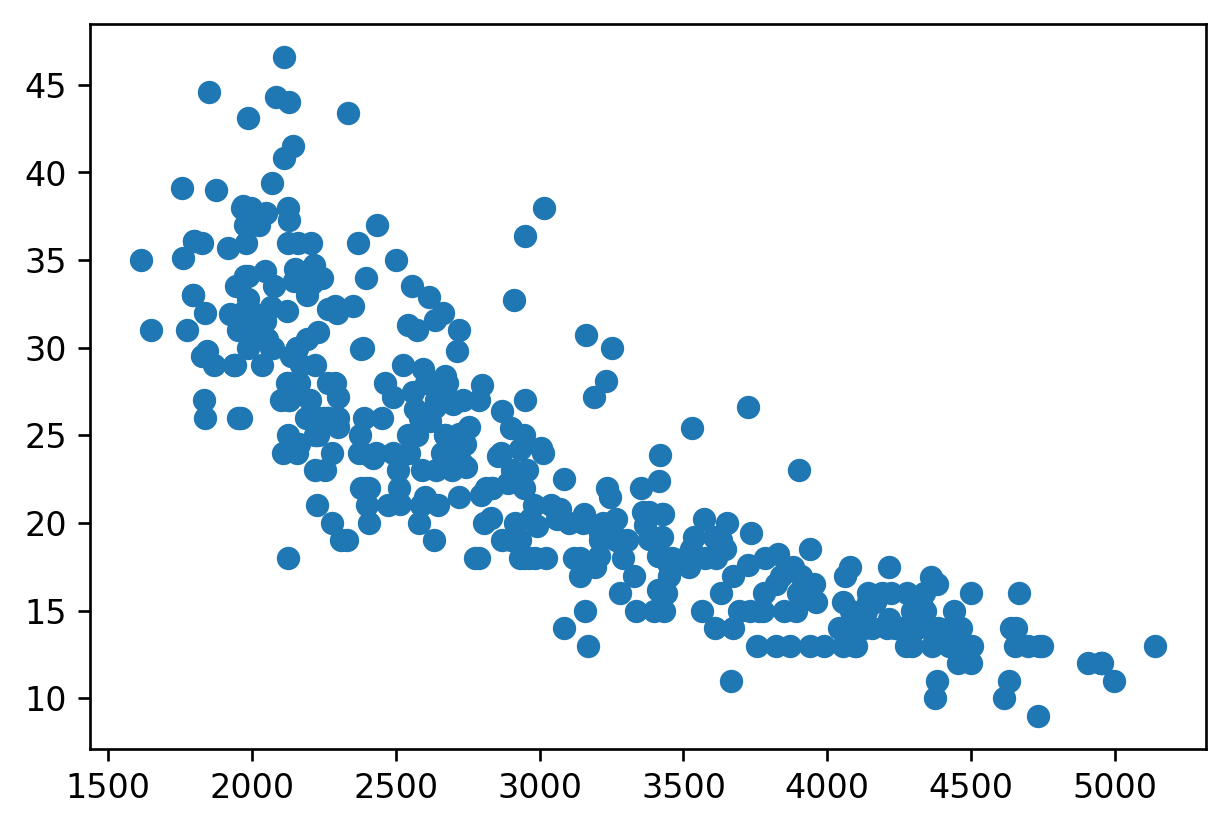

In [ ]:
plt.scatter(data['WGT'],data['MPG'])

In [ ]:
data.sort_values(by='WGT')

,MPG,CYL,ENG,WGT
53,35.000000,4,72.0,1613
142,31.000000,4,76.0,1649
339,39.099998,4,79.0,1755
341,35.099998,4,81.0,1760
52,31.000000,4,71.0,1773
...,...,...,...,...
94,12.000000,8,455.0,4951
89,12.000000,8,429.0,4952
41,12.000000,8,383.0,4955
102,11.000000,8,400.0,4997


In [ ]:
x = data['WGT'].values
y = data['MPG'].values

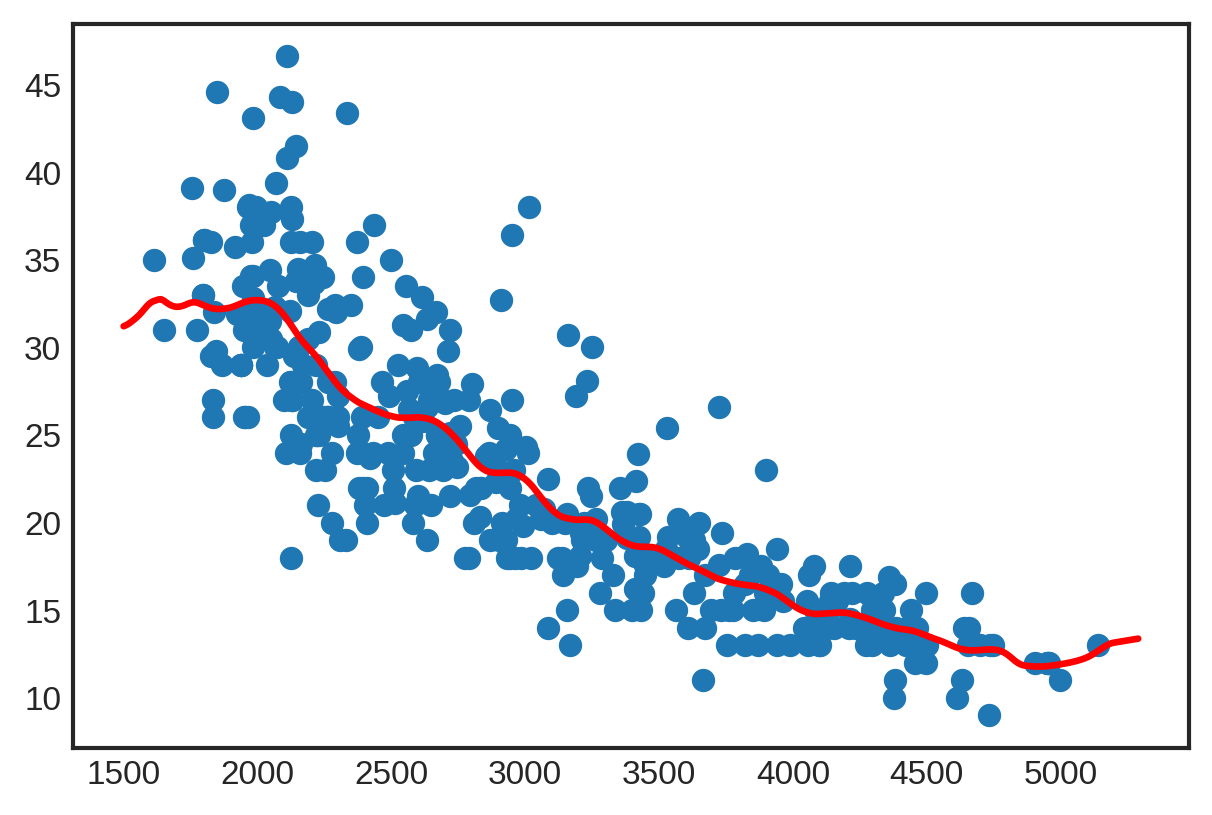

In [ ]:
plt.scatter(data['WGT'],data['MPG'])
plt.plot(xnew,yhat,color='red',lw=2)